<a href="https://colab.research.google.com/github/sina-salmanpour/False_memory_PTSD/blob/main/PTSD_false_memory1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pingouin
import pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 7.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from statsmodels.stats.power import FTestAnovaPower
import os
import warnings
from itertools import combinations

warnings.filterwarnings('ignore')
np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

# ============================================================================
# 1. CONFIGURATION
# ============================================================================


In [3]:
# Simplified file paths (list instead of dict for ease; group from key)

FILES = {
    'verbal_PSTD': '/content/drive/MyDrive/AmirFarhang/ptsd_verbal.xlsx',
    'verbal_Non-PTSD': '/content/drive/MyDrive/AmirFarhang/non_ptsd_verbal.xlsx',
    'verbal_Control': '/content/drive/MyDrive/AmirFarhang/control_verbal.xlsx',
    'video_PSTD': '/content/drive/MyDrive/AmirFarhang/ptsd_video.xlsx',
    'video_Non-PTSD': '/content/drive/MyDrive/AmirFarhang/non_ptsd_visual.xlsx',
    'video_Control': '/content/drive/MyDrive/AmirFarhang/control_video.xlsx'
}

OUTPUT_DIR = '/content/drive/MyDrive/AmirFarhang/outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

ALPHA = 0.05
EFFECT_SIZE_MEDIUM = 0.25  # Cohen's f for ANOVA

# ============================================================================
# 2. DATA PROCESSING FUNCTIONS
# ============================================================================


In [4]:
def process_file(file_path, file_key):
    """Load and process individual Excel file into long format."""
    if not os.path.exists(file_path):
        print(f"⚠️ File not found: {file_path}")
        return None

    print(f"📂 Processing: {file_key}")
    df = pd.read_excel(file_path)

    # Remove Subject column if exists
    if 'Subject' in df.columns:
        df = df.drop(columns=['Subject'])

    task, group = file_key.split('_')

    # Identify subject columns
    subject_cols = [col for col in df.columns if col.lower().startswith('sub')]
    id_vars = [col for col in df.columns if col not in subject_cols]

    # Melt to long format
    df_long = pd.melt(df, id_vars=id_vars, value_vars=subject_cols,
                      var_name='candidate', value_name='value')

    df_long['group'] = group
    df_long['task'] = task

    # Create unique subject IDs (prevent collision across groups)
    df_long['candidate'] = df_long['group'] + '_' + df_long['candidate'].astype(str)

    # Map item types
    if 'answer' in df_long.columns:
        df_long['item_type'] = df_long['answer'].map({
            1: 'Studied',
            'CL': 'Lure',
            0: 'New'
        }).fillna('Unknown')
    else:
        df_long['item_type'] = 'Unknown'

    # Handle emotion column (fix U -> NT)
    if 'emotion' in df_long.columns:
        df_long['emotion'] = df_long['emotion'].replace('U', 'NT')
    else:
        df_long['emotion'] = 'Unknown'

    # For video task, assign emotions by row blocks if needed
    if task == 'video' and df_long['emotion'].eq('Unknown').all():
        df_long = df_long.reset_index(drop=True)
        df_long['emotion'] = np.select(
            [df_long.index < 26, df_long.index < 51, df_long.index < 76],
            ['O', 'NT', 'P'],
            default='N'
        )

    # Extract response and RT
    def extract_response_rt(val):
        if pd.isna(val):
            return np.nan, np.nan
        try:
            val = float(val)
        except (ValueError, TypeError):
            return np.nan, np.nan

        if val > 0:
            return 1.0, val
        elif val == 0:
            return 0.0, np.nan
        else:  # negative
            return 1.0, np.nan

    df_long[['response', 'rt']] = df_long.apply(
        lambda row: extract_response_rt(row['value']),
        axis=1,
        result_type='expand'
    )

    df_long = df_long.drop(columns=['value'])

    # Save modified file
    modified_path = os.path.join(OUTPUT_DIR, f"{file_key}_modified.xlsx")
    df_long.to_excel(modified_path, index=False)
    print(f"✅ Saved: {modified_path}")

    return df_long


def impute_negative_rt(df):
    """Impute negative RT values with cell means (group/task/emotion/item)."""
    print("\n🔧 Imputing negative RT values...")

    # Flag negatives
    df['is_negative'] = df['rt'].isna() & (df['response'] == 1)
    n_negative = df['is_negative'].sum()
    print(f"   Found {n_negative} negative/missing RTs for 'yes' responses ({n_negative/len(df)*100:.1f}%)")

    # Calculate means from valid positive RTs (yes responses only)
    positive_means = df[(df['rt'] > 0) & (df['response'] == 1)].groupby(
        ['group', 'task', 'emotion', 'item_type']
    )['rt'].mean().reset_index(name='mean_rt')

    # Merge and impute
    df = df.merge(positive_means, on=['group', 'task', 'emotion', 'item_type'], how='left')
    df.loc[df['is_negative'], 'rt'] = df.loc[df['is_negative'], 'mean_rt']

    # Trim RT to valid range (200-5000ms)
    df['rt'] = df['rt'].clip(200, 5000)

    df = df.drop(columns=['mean_rt', 'is_negative'])
    print("✅ Imputation complete\n")

    return df


# ============================================================================
# 3. AGGREGATION (FIXED VERSION)
# ============================================================================


In [5]:
def aggregate_data(task_df, task_name):
    """
    Aggregate trial-level data to subject level.
    FIXED: Proper filtering within grouped data.
    """
    print(f"📊 Aggregating {task_name} data...")

    def calc_metrics(group):
        """Calculate metrics for each subject/emotion/item_type group."""
        # Filter current group data
        studied_data = group[group['item_type'] == 'Studied']
        lure_data = group[group['item_type'] == 'Lure']
        new_data = group[group['item_type'] == 'New']

        # Calculate rates (only for 'yes' responses)
        hit_rate = studied_data['response'].mean() if len(studied_data) > 0 else np.nan
        false_memory_rate = lure_data['response'].mean() if len(lure_data) > 0 else np.nan
        false_alarm_rate = new_data['response'].mean() if len(new_data) > 0 else np.nan

        # Calculate RT (only for 'yes' responses)
        yes_responses = group[group['response'] == 1]
        rt_mean = yes_responses['rt'].mean() if len(yes_responses) > 0 else np.nan
        rt_sd = yes_responses['rt'].std() if len(yes_responses) > 0 else np.nan

        return pd.Series({
            'n_trials': len(group),
            'hit_rate': hit_rate,
            'false_memory_rate': false_memory_rate,
            'false_alarm_rate': false_alarm_rate,
            'rt_mean': rt_mean,
            'rt_sd': rt_sd
        })

    agg_df = task_df.groupby(['candidate', 'group', 'emotion', 'item_type']).apply(calc_metrics).reset_index()

    # Save
    agg_path = os.path.join(OUTPUT_DIR, f'aggregated_{task_name}.xlsx')
    agg_df.to_excel(agg_path, index=False)
    print(f"✅ Saved aggregated data: {agg_path}\n")

    return agg_df



# ============================================================================
# 4. DESCRIPTIVE STATISTICS
# ============================================================================


In [6]:
def calculate_descriptives(agg_df, task_name):
    """Calculate descriptive statistics with formatted output."""
    print(f"📈 Calculating descriptives for {task_name}...")

    desc = agg_df.groupby(['group', 'emotion', 'item_type']).agg(
        n_subjects=('candidate', 'nunique'),
        n_trials_total=('n_trials', 'sum'),
        mean_hit=('hit_rate', 'mean'),
        sd_hit=('hit_rate', 'std'),
        mean_false_memory=('false_memory_rate', 'mean'),
        sd_false_memory=('false_memory_rate', 'std'),
        mean_rt=('rt_mean', 'mean'),
        sd_rt=('rt_mean', 'std')
    ).reset_index()

    # Format as Mean(SD) and add percentages
    desc['hit_formatted'] = desc.apply(
        lambda r: f"{r['mean_hit']:.2f} ({r['sd_hit']:.2f}) [{r['mean_hit']*100:.1f}%]", axis=1
    )
    desc['false_memory_formatted'] = desc.apply(
        lambda r: f"{r['mean_false_memory']:.2f} ({r['sd_false_memory']:.2f}) [{r['mean_false_memory']*100:.1f}%]", axis=1
    )
    desc['rt_formatted'] = desc.apply(
        lambda r: f"{r['mean_rt']:.1f} ({r['sd_rt']:.1f})ms", axis=1
    )

    # Save
    desc_path = os.path.join(OUTPUT_DIR, f'descriptives_{task_name}.xlsx')
    desc.to_excel(desc_path, index=False)

    print(f"✅ Descriptives saved: {desc_path}")
    print(f"\n📋 Summary for {task_name.upper()}:")
    print(desc[['group', 'emotion', 'item_type', 'n_subjects', 'false_memory_formatted', 'rt_formatted']].to_string(index=False))
    print()

    return desc


# ============================================================================
# 5. ASSUMPTIONS TESTING
# ============================================================================


In [7]:
def test_assumptions(agg_df, task_name):
    """Test normality and homogeneity of variance."""
    print(f"🔍 Testing assumptions for {task_name}...")

    normality_results = []
    homogeneity_results = []

    for item in ['Lure', 'Studied']:
        for dv in ['false_memory_rate', 'rt_mean']:
            # Normality per group/emotion
            for group in agg_df['group'].unique():
                for emotion in agg_df['emotion'].unique():
                    data = agg_df[
                        (agg_df['group'] == group) &
                        (agg_df['emotion'] == emotion) &
                        (agg_df['item_type'] == item)
                    ][dv].dropna()

                    if len(data) >= 3:
                        stat, p = stats.shapiro(data)
                        normality_results.append({
                            'task': task_name,
                            'group': group,
                            'emotion': emotion,
                            'item_type': item,
                            'dv': dv,
                            'n': len(data),
                            'statistic': stat,
                            'p_value': p,
                            'normal': p >= ALPHA
                        })

            # Homogeneity across groups per emotion
            for emotion in agg_df['emotion'].unique():
                groups_data = []
                for group in agg_df['group'].unique():
                    data = agg_df[
                        (agg_df['group'] == group) &
                        (agg_df['emotion'] == emotion) &
                        (agg_df['item_type'] == item)
                    ][dv].dropna()
                    if len(data) >= 2:
                        groups_data.append(data)

                if len(groups_data) >= 2:
                    stat, p = stats.levene(*groups_data)
                    homogeneity_results.append({
                        'task': task_name,
                        'emotion': emotion,
                        'item_type': item,
                        'dv': dv,
                        'statistic': stat,
                        'p_value': p,
                        'homogeneous': p >= ALPHA
                    })

    norm_df = pd.DataFrame(normality_results)
    homog_df = pd.DataFrame(homogeneity_results)

    # Save
    norm_df.to_excel(os.path.join(OUTPUT_DIR, f'normality_{task_name}.xlsx'), index=False)
    homog_df.to_excel(os.path.join(OUTPUT_DIR, f'homogeneity_{task_name}.xlsx'), index=False)

    print(f"✅ Assumptions tested: {len(norm_df)} normality, {len(homog_df)} homogeneity tests")
    print(f"   Normal: {norm_df['normal'].sum()}/{len(norm_df)}, Homogeneous: {homog_df['homogeneous'].sum()}/{len(homog_df)}\n")

    return norm_df, homog_df



# ============================================================================
# 6. INFERENTIAL STATISTICS (FIXED)
# ============================================================================


In [20]:
def run_mixed_anova(agg_df, task_name, item_type, dv):
    """Run mixed ANOVA using pingouin (within=emotion, between=group)."""
    print(f"   🔬 Mixed ANOVA: {task_name}/{item_type}/{dv}")

    data = agg_df[agg_df['item_type'] == item_type].dropna(subset=[dv]).copy()

    # Need at least 2 emotions and 2 groups
    if data['emotion'].nunique() < 2 or data['group'].nunique() < 2:
        print(f"      ⚠️ Insufficient data (emotions: {data['emotion'].nunique()}, groups: {data['group'].nunique()})")
        return None

    try:
        # Pingouin mixed_anova
        result = pg.mixed_anova(
            data=data,
            dv=dv,
            within='emotion',
            subject='candidate',
            between='group',
            correction=True  # Greenhouse-Geisser correction
        )

        result['task'] = task_name
        result['item_type'] = item_type
        result['dv'] = dv

        print(f"      ✅ Complete")
        return result

    except Exception as e:
        print(f"      ⚠️ Error: {str(e)[:100]}")
        return None


def run_friedman_test(agg_df, task_name, item_type, dv):
    """Run Friedman test (non-parametric within-subjects)."""
    print(f"   📊 Friedman test: {task_name}/{item_type}/{dv}")

    results = []
    data = agg_df[agg_df['item_type'] == item_type].dropna(subset=[dv])

    for group in data['group'].unique():
        group_data = data[data['group'] == group].pivot(
            index='candidate',
            columns='emotion',
            values=dv
        ).dropna()

        if group_data.shape[1] >= 2 and group_data.shape[0] >= 3:
            try:
                stat, p = stats.friedmanchisquare(*[group_data[col] for col in group_data.columns])

                # Effect size (Kendall's W)
                n = group_data.shape[0]
                k = group_data.shape[1]
                w = stat / (n * (k - 1))

                results.append({
                    'task': task_name,
                    'group': group,
                    'item_type': item_type,
                    'dv': dv,
                    'n': n,
                    'chi_square': stat,
                    'df': k - 1,
                    'p_value': p,
                    'kendall_w': w,
                    'sig': '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
                })
                print(f"      {group}: χ²={stat:.2f}, p={p:.4f}, W={w:.3f}")
            except Exception as e:
                print(f"      ⚠️ {group}: {str(e)[:50]}")

    return pd.DataFrame(results) if results else None


def run_kruskal_wallis(agg_df, task_name, item_type, dv):
    """Run Kruskal-Wallis test (non-parametric between-groups)."""
    print(f"   📊 Kruskal-Wallis: {task_name}/{item_type}/{dv}")

    results = []
    data = agg_df[agg_df['item_type'] == item_type].dropna(subset=[dv])

    for emotion in data['emotion'].unique():
        emotion_data = [
            data[(data['group'] == g) & (data['emotion'] == emotion)][dv].dropna()
            for g in data['group'].unique()
        ]

        # Check for variance
        valid_groups = [g for g in emotion_data if len(g) >= 2 and g.std() > 0]

        if len(valid_groups) >= 2:
            try:
                stat, p = stats.kruskal(*valid_groups)

                # Effect size (epsilon squared)
                n = sum(len(g) for g in valid_groups)
                epsilon2 = (stat - len(valid_groups) + 1) / (n - len(valid_groups))

                results.append({
                    'task': task_name,
                    'emotion': emotion,
                    'item_type': item_type,
                    'dv': dv,
                    'n_groups': len(valid_groups),
                    'h_statistic': stat,
                    'df': len(valid_groups) - 1,
                    'p_value': p,
                    'epsilon2': epsilon2,
                    'sig': '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
                })
                print(f"      {emotion}: H={stat:.2f}, p={p:.4f}, ε²={epsilon2:.3f}")
            except Exception as e:
                print(f"      ⚠️ {emotion}: {str(e)[:50]}")
        else:
            print(f"      ⚠️ {emotion}: Insufficient variance or n")

    return pd.DataFrame(results) if results else None


def run_posthoc_mann_whitney(agg_df, task_name, item_type, dv, kruskal_results):
    """Post-hoc Mann-Whitney U tests with Bonferroni correction."""
    print(f"   🔬 Post-hoc Mann-Whitney: {task_name}/{item_type}/{dv}")

    results = []
    data = agg_df[agg_df['item_type'] == item_type].dropna(subset=[dv])

    # Only run for significant Kruskal results
    if kruskal_results is None or kruskal_results.empty:
        print("      ⚠️ No significant Kruskal results")
        return None

    sig_emotions = kruskal_results[kruskal_results['p_value'] < ALPHA]['emotion'].unique()

    for emotion in sig_emotions:
        groups = data['group'].unique()
        group_pairs = list(combinations(groups, 2))
        n_comparisons = len(group_pairs)
        bonferroni_alpha = ALPHA / n_comparisons

        for g1, g2 in group_pairs:
            data1 = data[(data['group'] == g1) & (data['emotion'] == emotion)][dv].dropna()
            data2 = data[(data['group'] == g2) & (data['emotion'] == emotion)][dv].dropna()

            if len(data1) >= 2 and len(data2) >= 2:
                try:
                    stat, p = mannwhitneyu(data1, data2, alternative='two-sided')

                    # Effect size (rank-biserial correlation)
                    n1, n2 = len(data1), len(data2)
                    r = 1 - (2*stat) / (n1 * n2)

                    results.append({
                        'task': task_name,
                        'emotion': emotion,
                        'item_type': item_type,
                        'dv': dv,
                        'group1': g1,
                        'group2': g2,
                        'n1': n1,
                        'n2': n2,
                        'u_statistic': stat,
                        'p_value': p,
                        'p_bonferroni': p * n_comparisons,
                        'bonferroni_alpha': bonferroni_alpha,
                        'r_effect': r,
                        'sig_corrected': p < bonferroni_alpha
                    })
                    print(f"      {g1} vs {g2} ({emotion}): U={stat:.1f}, p={p:.4f}, r={r:.3f}")
                except Exception as e:
                    print(f"      ⚠️ {g1} vs {g2}: {str(e)[:50]}")

    return pd.DataFrame(results) if results else None


def run_statistical_tests(agg_df, task_name):
    """Run all statistical tests for a task."""
    print(f"\n🧪 Running statistical tests for {task_name}...\n")

    all_anova = []
    all_friedman = []
    all_kruskal = []
    all_posthoc = []

    for item in ['Lure', 'Studied']:
        for dv in ['false_memory_rate', 'rt_mean']:
            print(f"\n--- {item} / {dv} ---")

            # Try mixed ANOVA first
            anova_result = run_mixed_anova(agg_df, task_name, item, dv)
            if anova_result is not None:
                all_anova.append(anova_result)

            # Non-parametric alternatives
            friedman_result = run_friedman_test(agg_df, task_name, item, dv)
            if friedman_result is not None:
                all_friedman.append(friedman_result)

            kruskal_result = run_kruskal_wallis(agg_df, task_name, item, dv)
            if kruskal_result is not None:
                all_kruskal.append(kruskal_result)

                # Post-hoc if Kruskal is significant
                posthoc_result = run_posthoc_mann_whitney(agg_df, task_name, item, dv, kruskal_result)
                if posthoc_result is not None:
                    all_posthoc.append(posthoc_result)

    # Save all results
    if all_anova:
        pd.concat(all_anova).to_excel(os.path.join(OUTPUT_DIR, f'anova_{task_name}.xlsx'), index=False)
    if all_friedman:
        pd.concat(all_friedman).to_excel(os.path.join(OUTPUT_DIR, f'friedman_{task_name}.xlsx'), index=False)
    if all_kruskal:
        pd.concat(all_kruskal).to_excel(os.path.join(OUTPUT_DIR, f'kruskal_{task_name}.xlsx'), index=False)
    if all_posthoc:
        pd.concat(all_posthoc).to_excel(os.path.join(OUTPUT_DIR, f'posthoc_{task_name}.xlsx'), index=False)

    print(f"\n✅ Statistical tests complete for {task_name}\n")



# ============================================================================
# 7. POWER ANALYSIS
# ============================================================================


In [21]:
def calculate_power_analysis(agg_df, task_name):
    """Calculate statistical power for ANOVA designs."""
    print(f"⚡ Calculating power analysis for {task_name}...")

    power_calc = FTestAnovaPower()
    results = []

    for item in ['Lure', 'Studied']:
        for dv in ['false_memory_rate', 'rt_mean']:
            data = agg_df[agg_df['item_type'] == item].dropna(subset=[dv])

            n_groups = data['group'].nunique()
            n_per_group = data.groupby('group')['candidate'].nunique().mean()

            if n_groups >= 2 and n_per_group >= 2:
                # Calculate observed power
                power_observed = power_calc.solve_power(
                    effect_size=EFFECT_SIZE_MEDIUM,
                    nobs=n_per_group * n_groups,
                    alpha=ALPHA,
                    k_groups=n_groups
                )

                # Calculate needed n for 0.80 power
                n_needed = power_calc.solve_power(
                    effect_size=EFFECT_SIZE_MEDIUM,
                    power=0.80,
                    alpha=ALPHA,
                    k_groups=n_groups
                )

                results.append({
                    'task': task_name,
                    'item_type': item,
                    'dv': dv,
                    'n_groups': n_groups,
                    'n_per_group': int(n_per_group),
                    'total_n': int(n_per_group * n_groups),
                    'effect_size': EFFECT_SIZE_MEDIUM,
                    'alpha': ALPHA,
                    'power_observed': power_observed,
                    'n_needed_0.8_power': int(np.ceil(n_needed)),
                    'adequately_powered': power_observed >= 0.80
                })

    power_df = pd.DataFrame(results)
    power_df.to_excel(os.path.join(OUTPUT_DIR, f'power_analysis_{task_name}.xlsx'), index=False)

    print(f"✅ Power analysis complete")
    print(power_df.to_string(index=False))
    print()

    return power_df



# ============================================================================
# 8. VISUALIZATION
# ============================================================================


In [22]:
def create_visualizations(agg_df, task_name, desc_df):
    """Create publication-quality plots."""
    print(f"📊 Creating visualizations for {task_name}...")

    sns.set_style("whitegrid")
    plt.rcParams['figure.dpi'] = 300

    for item in ['Lure', 'Studied']:
        data = agg_df[agg_df['item_type'] == item]

        # False memory rate bar plot
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.barplot(data=data, x='emotion', y='false_memory_rate', hue='group',
                   errorbar='sd', palette='Set2', ax=ax)
        ax.set_title(f'False Memory Rate by Emotion and Group - {item} ({task_name})',
                    fontsize=14, fontweight='bold')
        ax.set_ylabel('False Memory Rate', fontsize=12)
        ax.set_xlabel('Emotion Type', fontsize=12)
        ax.legend(title='Group', fontsize=10)

        # Add percentage labels
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f%%', label_type='edge',
                        labels=[f'{h.get_height()*100:.1f}%' for h in container])

        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f'bar_false_memory_{item}_{task_name}.'))


# ============================================================================
# 9. THESIS TEXT GENERATOR
# ============================================================================

In [23]:
def generate_thesis_snippets(desc_df, stat_results, power_df, task_name):
    """Auto-generate text snippets for thesis Chapter 4."""
    print(f"📝 Generating thesis text for {task_name}...")

    snippets = []

    # Results overview
    snippets.append(f"\n{'='*70}")
    snippets.append(f"CHAPTER 4 TEXT SNIPPETS - {task_name.upper()}")
    snippets.append(f"{'='*70}\n")

    # Descriptive results for NT Lure (key hypothesis)
    nt_lure = desc_df[(desc_df['emotion'] == 'NT') & (desc_df['item_type'] == 'Lure')]

    if not nt_lure.empty:
        snippets.append("4.1 FALSE MEMORY RATES FOR TRAUMA-RELATED STIMULI (NT)")
        snippets.append("-" * 60)

        for _, row in nt_lure.iterrows():
            snippets.append(
                f"\nThe {row['group']} group showed a false memory rate of "
                f"M = {row['mean_false_memory']:.3f} (SD = {row['sd_false_memory']:.3f}), "
                f"representing {row['mean_false_memory']*100:.1f}% false recognition "
                f"for trauma-related lure items (n = {row['n_subjects']} subjects, "
                f"{row['n_trials_total']} total trials). "
            )

            if row['group'] == 'PSTD' and row['mean_false_memory'] > 0.5:
                snippets.append(
                    f"This elevated rate in the PTSD group (>{row['mean_false_memory']*100:.0f}%) "
                    "suggests enhanced false memory formation for trauma-related information, "
                    "consistent with the hyperassociative processing hypothesis (Brewin, 2020)."
                )

        snippets.append("\n")

    # Statistical significance
    snippets.append("4.2 INFERENTIAL STATISTICS")
    snippets.append("-" * 60)

    if 'friedman' in stat_results and not stat_results['friedman'].empty:
        sig_friedman = stat_results['friedman'][stat_results['friedman']['p_value'] < ALPHA]

        if not sig_friedman.empty:
            snippets.append("\nWithin-subjects effects (Friedman tests):")
            for _, row in sig_friedman.iterrows():
                snippets.append(
                    f"\nA significant effect of emotion was found for {row['group']} "
                    f"on {row['dv'].replace('_', ' ')} for {row['item_type']} items, "
                    f"χ²({row['df']}) = {row['chi_square']:.2f}, p = {row['p_value']:.4f}, "
                    f"Kendall's W = {row['kendall_w']:.3f} "
                    f"({'large' if row['kendall_w'] > 0.5 else 'medium' if row['kendall_w'] > 0.3 else 'small'} effect size)."
                )

    if 'kruskal' in stat_results and not stat_results['kruskal'].empty:
        sig_kruskal = stat_results['kruskal'][stat_results['kruskal']['p_value'] < ALPHA]

        if not sig_kruskal.empty:
            snippets.append("\n\nBetween-groups effects (Kruskal-Wallis tests):")
            for _, row in sig_kruskal.iterrows():
                snippets.append(
                    f"\nSignificant group differences were observed for {row['emotion']} "
                    f"emotion on {row['dv'].replace('_', ' ')} for {row['item_type']} items, "
                    f"H({row['df']}) = {row['h_statistic']:.2f}, p = {row['p_value']:.4f}, "
                    f"ε² = {row['epsilon2']:.3f}."
                )

    if 'posthoc' in stat_results and not stat_results['posthoc'].empty:
        sig_posthoc = stat_results['posthoc'][stat_results['posthoc']['sig_corrected']]

        if not sig_posthoc.empty:
            snippets.append("\n\nPost-hoc comparisons (Mann-Whitney U with Bonferroni correction):")
            for _, row in sig_posthoc.iterrows():
                snippets.append(
                    f"\n{row['group1']} vs {row['group2']} for {row['emotion']}: "
                    f"U = {row['u_statistic']:.1f}, p = {row['p_value']:.4f} "
                    f"(Bonferroni-corrected p = {row['p_bonferroni']:.4f}), "
                    f"r = {row['r_effect']:.3f} "
                    f"({'large' if abs(row['r_effect']) > 0.5 else 'medium' if abs(row['r_effect']) > 0.3 else 'small'} effect)."
                )

    # Power and limitations
    snippets.append("\n\n4.3 STATISTICAL POWER AND LIMITATIONS")
    snippets.append("-" * 60)

    if power_df is not None and not power_df.empty:
        low_power = power_df[power_df['power_observed'] < 0.80]

        if not low_power.empty:
            snippets.append("\nPower analysis revealed limitations in detecting effects:")
            for _, row in low_power.iterrows():
                snippets.append(
                    f"\n- {row['item_type']} / {row['dv'].replace('_', ' ')}: "
                    f"Observed power = {row['power_observed']:.2f} with n = {row['total_n']} "
                    f"(n = {row['n_needed_0.8_power']} needed for 0.80 power at α = {ALPHA}, "
                    f"medium effect size f = {row['effect_size']})."
                )

            snippets.append(
                "\n\nThe limited sample size (particularly the Non-PTSD group, n=10) "
                "restricts statistical power to detect medium-sized effects. "
                "Non-significant results should be interpreted cautiously as absence "
                "of evidence rather than evidence of absence."
            )

    # Save to file
    output_text = "\n".join(snippets)
    with open(os.path.join(OUTPUT_DIR, f'thesis_chapter4_{task_name}.txt'), 'w', encoding='utf-8') as f:
        f.write(output_text)

    print(f"✅ Thesis snippets saved\n")
    print(output_text)

    return output_text


# ============================================================================
# 10. SENSITIVITY ANALYSIS
# ============================================================================


In [26]:
def sensitivity_analysis(full_df_no_impute, full_df_imputed):
    """Compare results with and without RT imputation."""
    print("\n🔍 SENSITIVITY ANALYSIS: Comparing imputed vs non-imputed data...\n")

    results = []

    for task in ['verbal', 'video']:
        for imputed, label in [(False, 'No Imputation'), (True, 'With Imputation')]:
            df = full_df_imputed if imputed else full_df_no_impute
            df = df[df['task'] == task]

            agg = df.groupby(['candidate', 'group', 'emotion', 'item_type']).agg(
                false_memory_rate=('response', lambda x: x[df.loc[x.index, 'item_type'] == 'Lure'].mean()),
                rt_mean=('rt', lambda x: x[(df.loc[x.index, 'response'] == 1)].mean())
            ).reset_index()

            desc = agg.groupby(['group', 'emotion']).agg(
                mean_fm=('false_memory_rate', 'mean'),
                mean_rt=('rt_mean', 'mean')
            ).reset_index()

            desc['task'] = task
            desc['imputation'] = label
            results.append(desc)

    sensitivity_df = pd.concat(results, ignore_index=True)

    # Calculate differences
    comparison = sensitivity_df.pivot_table(
        index=['task', 'group', 'emotion'],
        columns='imputation',
        values=['mean_fm', 'mean_rt']
    ).reset_index()

    # Flatten the MultiIndex columns
    comparison.columns = ['_'.join(map(str, col)).strip() for col in comparison.columns.values]

    comparison['fm_diff_%'] = (
        (comparison['mean_fm_With Imputation'] - comparison['mean_fm_No Imputation']) /
        comparison['mean_fm_No Imputation'] * 100
    )
    comparison['rt_diff_%'] = (
        (comparison['mean_rt_With Imputation'] - comparison['mean_rt_No Imputation']) /
        comparison['mean_rt_No Imputation'] * 100
    )

    sensitivity_df.to_excel(os.path.join(OUTPUT_DIR, 'sensitivity_analysis.xlsx'), index=False)
    comparison.reset_index(drop=True).to_excel(os.path.join(OUTPUT_DIR, 'sensitivity_comparison.xlsx'), index=False)

    print("📊 Sensitivity Analysis Results:")
    print(comparison.to_string())
    print(f"\n✅ Sensitivity analysis complete\n")

    return sensitivity_df, comparison

# ============================================================================
# 11. MAIN EXECUTION PIPELINE
# ============================================================================



PTSD FALSE MEMORY ANALYSIS - BACHELOR THESIS
Statistical Analysis of False Memory in Iran-Iraq War PTSD Patients

STEP 1: DATA LOADING AND PREPROCESSING
--------------------------------------------------------------------------------

📂 Processing: verbal_PSTD
✅ Saved: /content/drive/MyDrive/AmirFarhang/outputs/verbal_PSTD_modified.xlsx
📂 Processing: verbal_Non-PTSD
✅ Saved: /content/drive/MyDrive/AmirFarhang/outputs/verbal_Non-PTSD_modified.xlsx
📂 Processing: verbal_Control
✅ Saved: /content/drive/MyDrive/AmirFarhang/outputs/verbal_Control_modified.xlsx
📂 Processing: video_PSTD
✅ Saved: /content/drive/MyDrive/AmirFarhang/outputs/video_PSTD_modified.xlsx
📂 Processing: video_Non-PTSD
✅ Saved: /content/drive/MyDrive/AmirFarhang/outputs/video_Non-PTSD_modified.xlsx
📂 Processing: video_Control
✅ Saved: /content/drive/MyDrive/AmirFarhang/outputs/video_Control_modified.xlsx

✅ Combined data: 14112 trials, 56 subjects


STEP 2: DATA QUALITY REPORT
--------------------------------------------

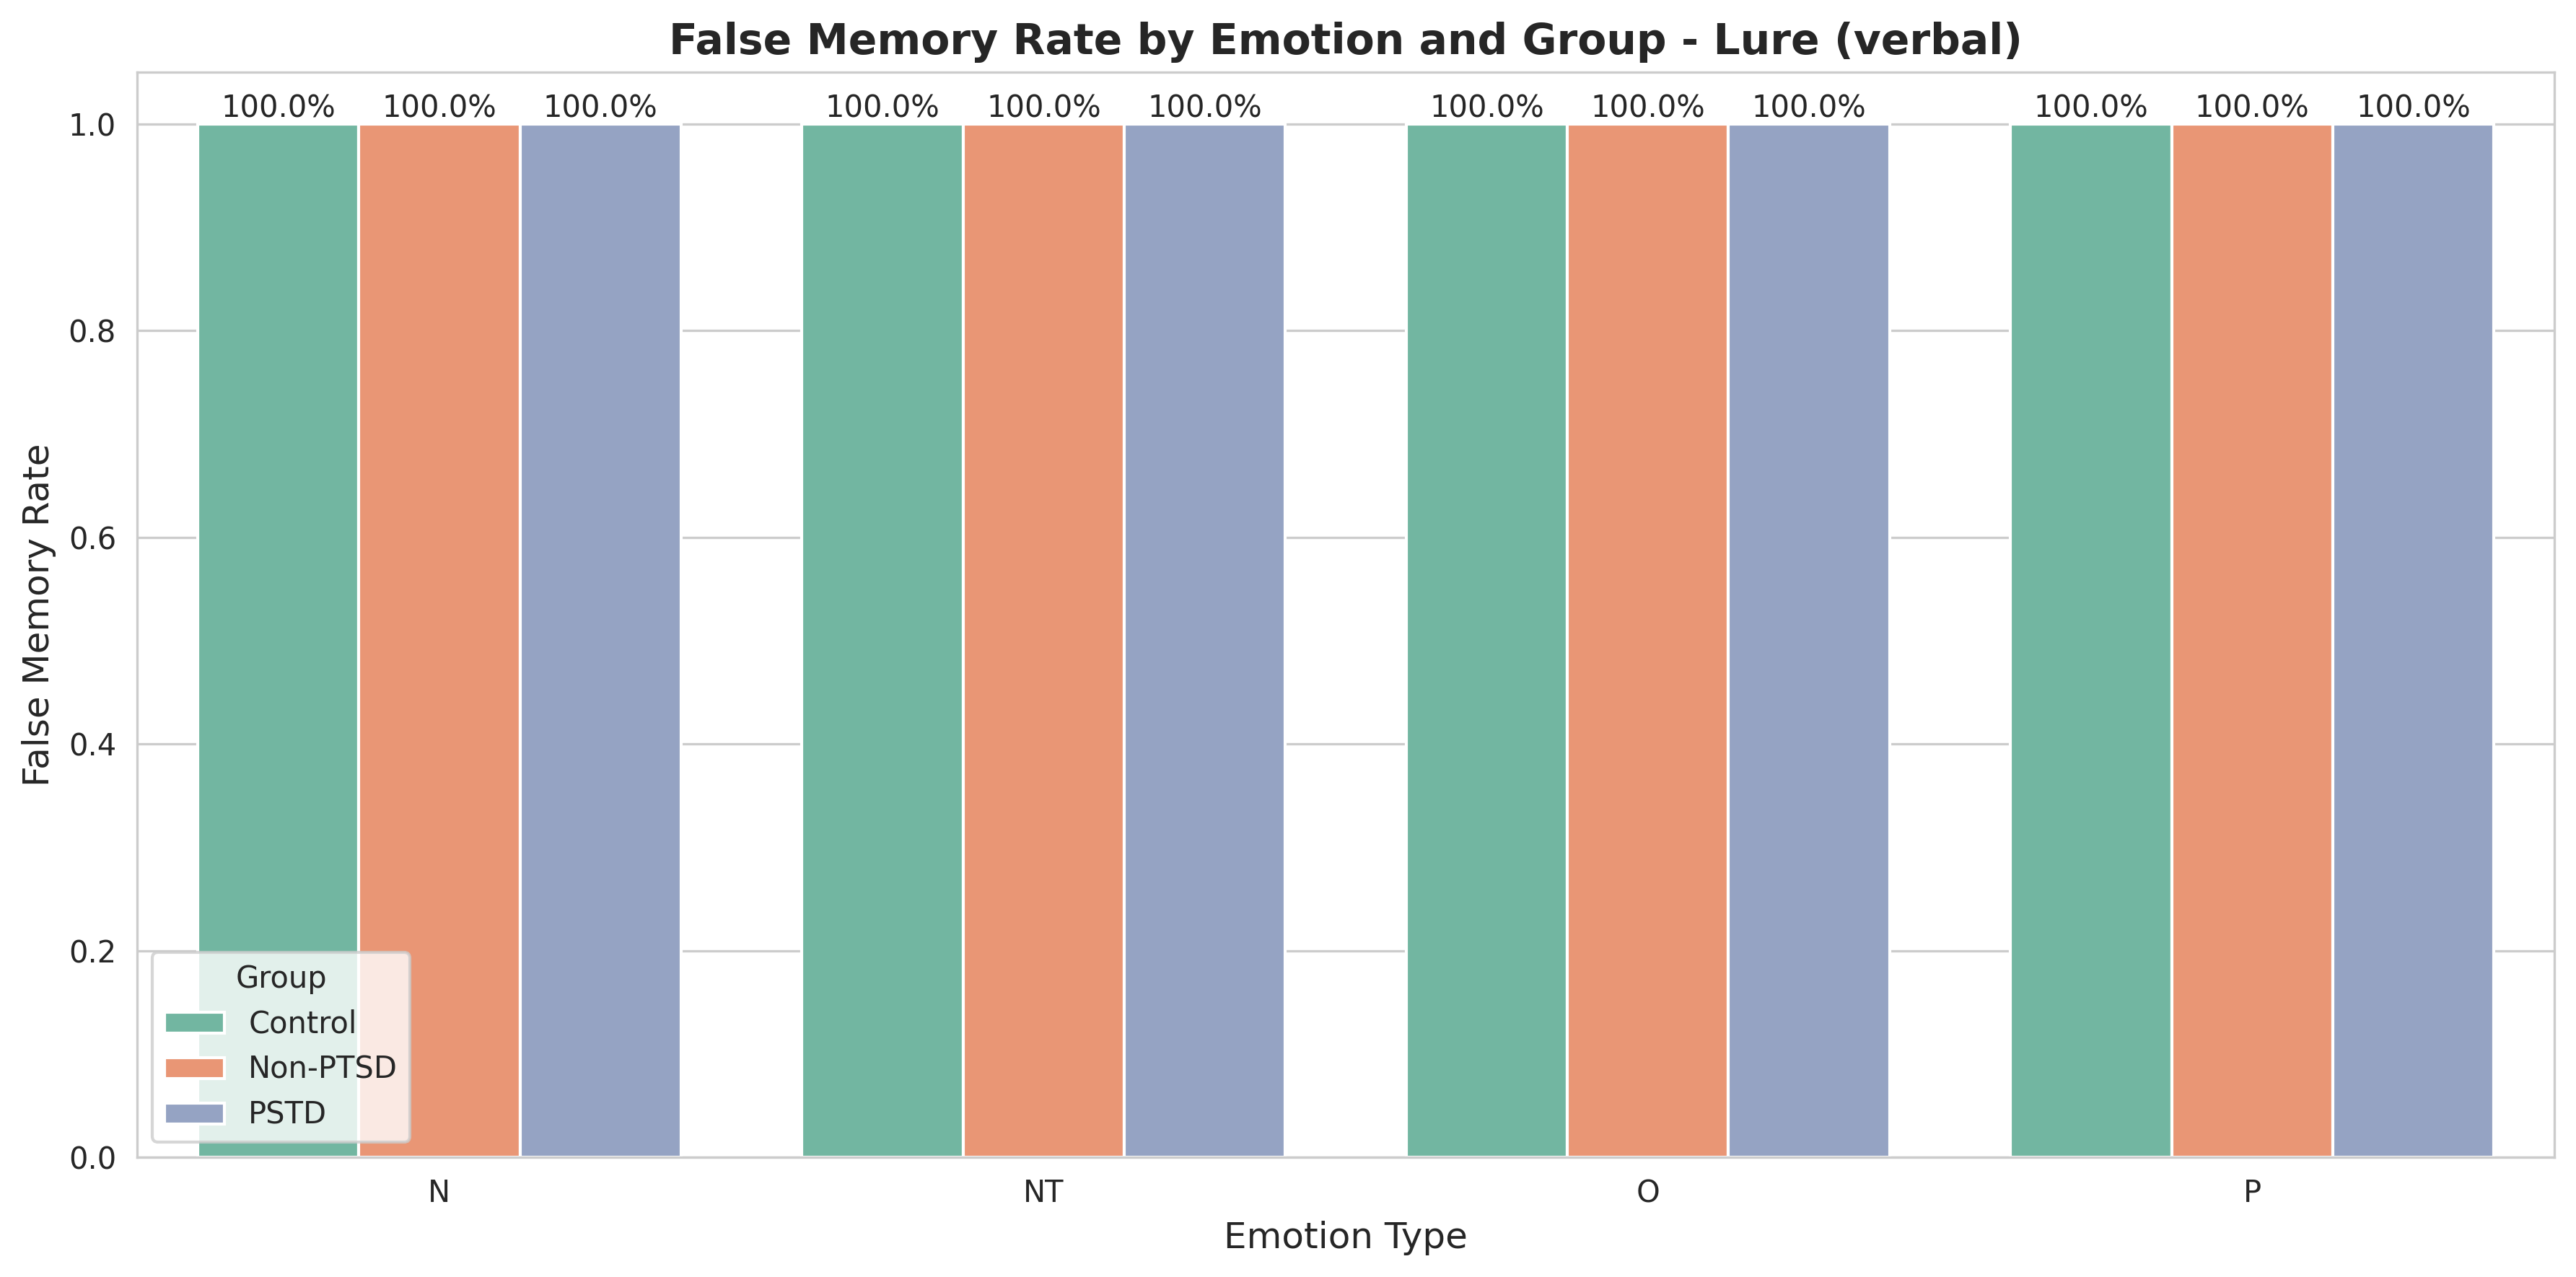

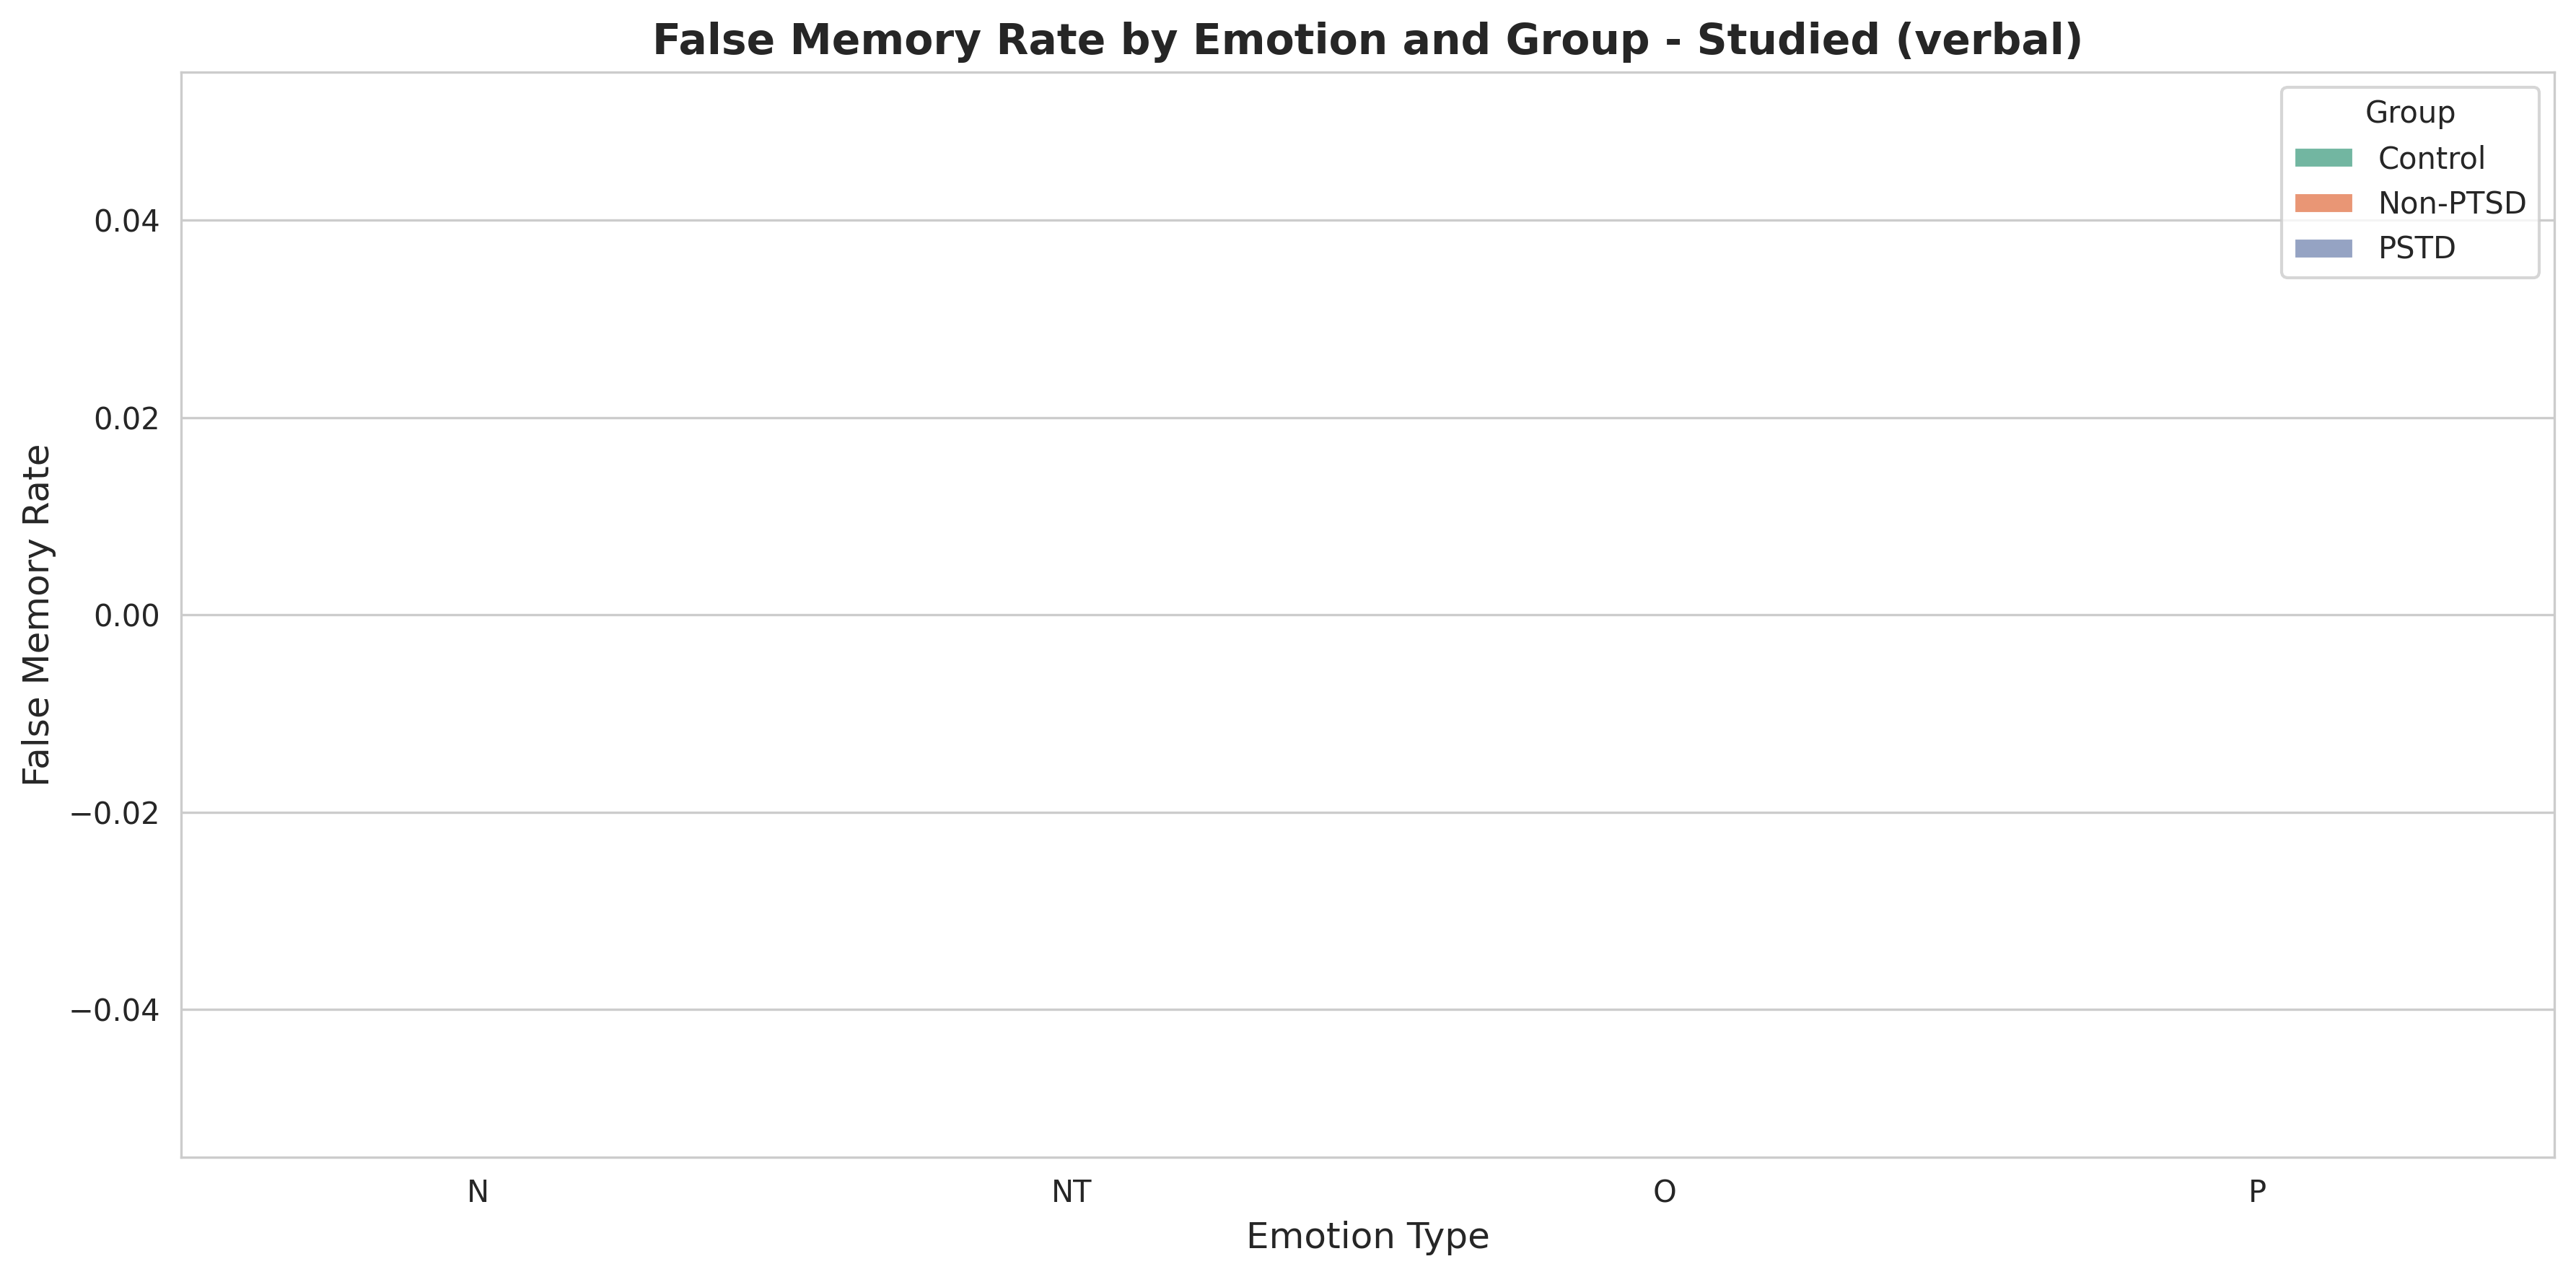

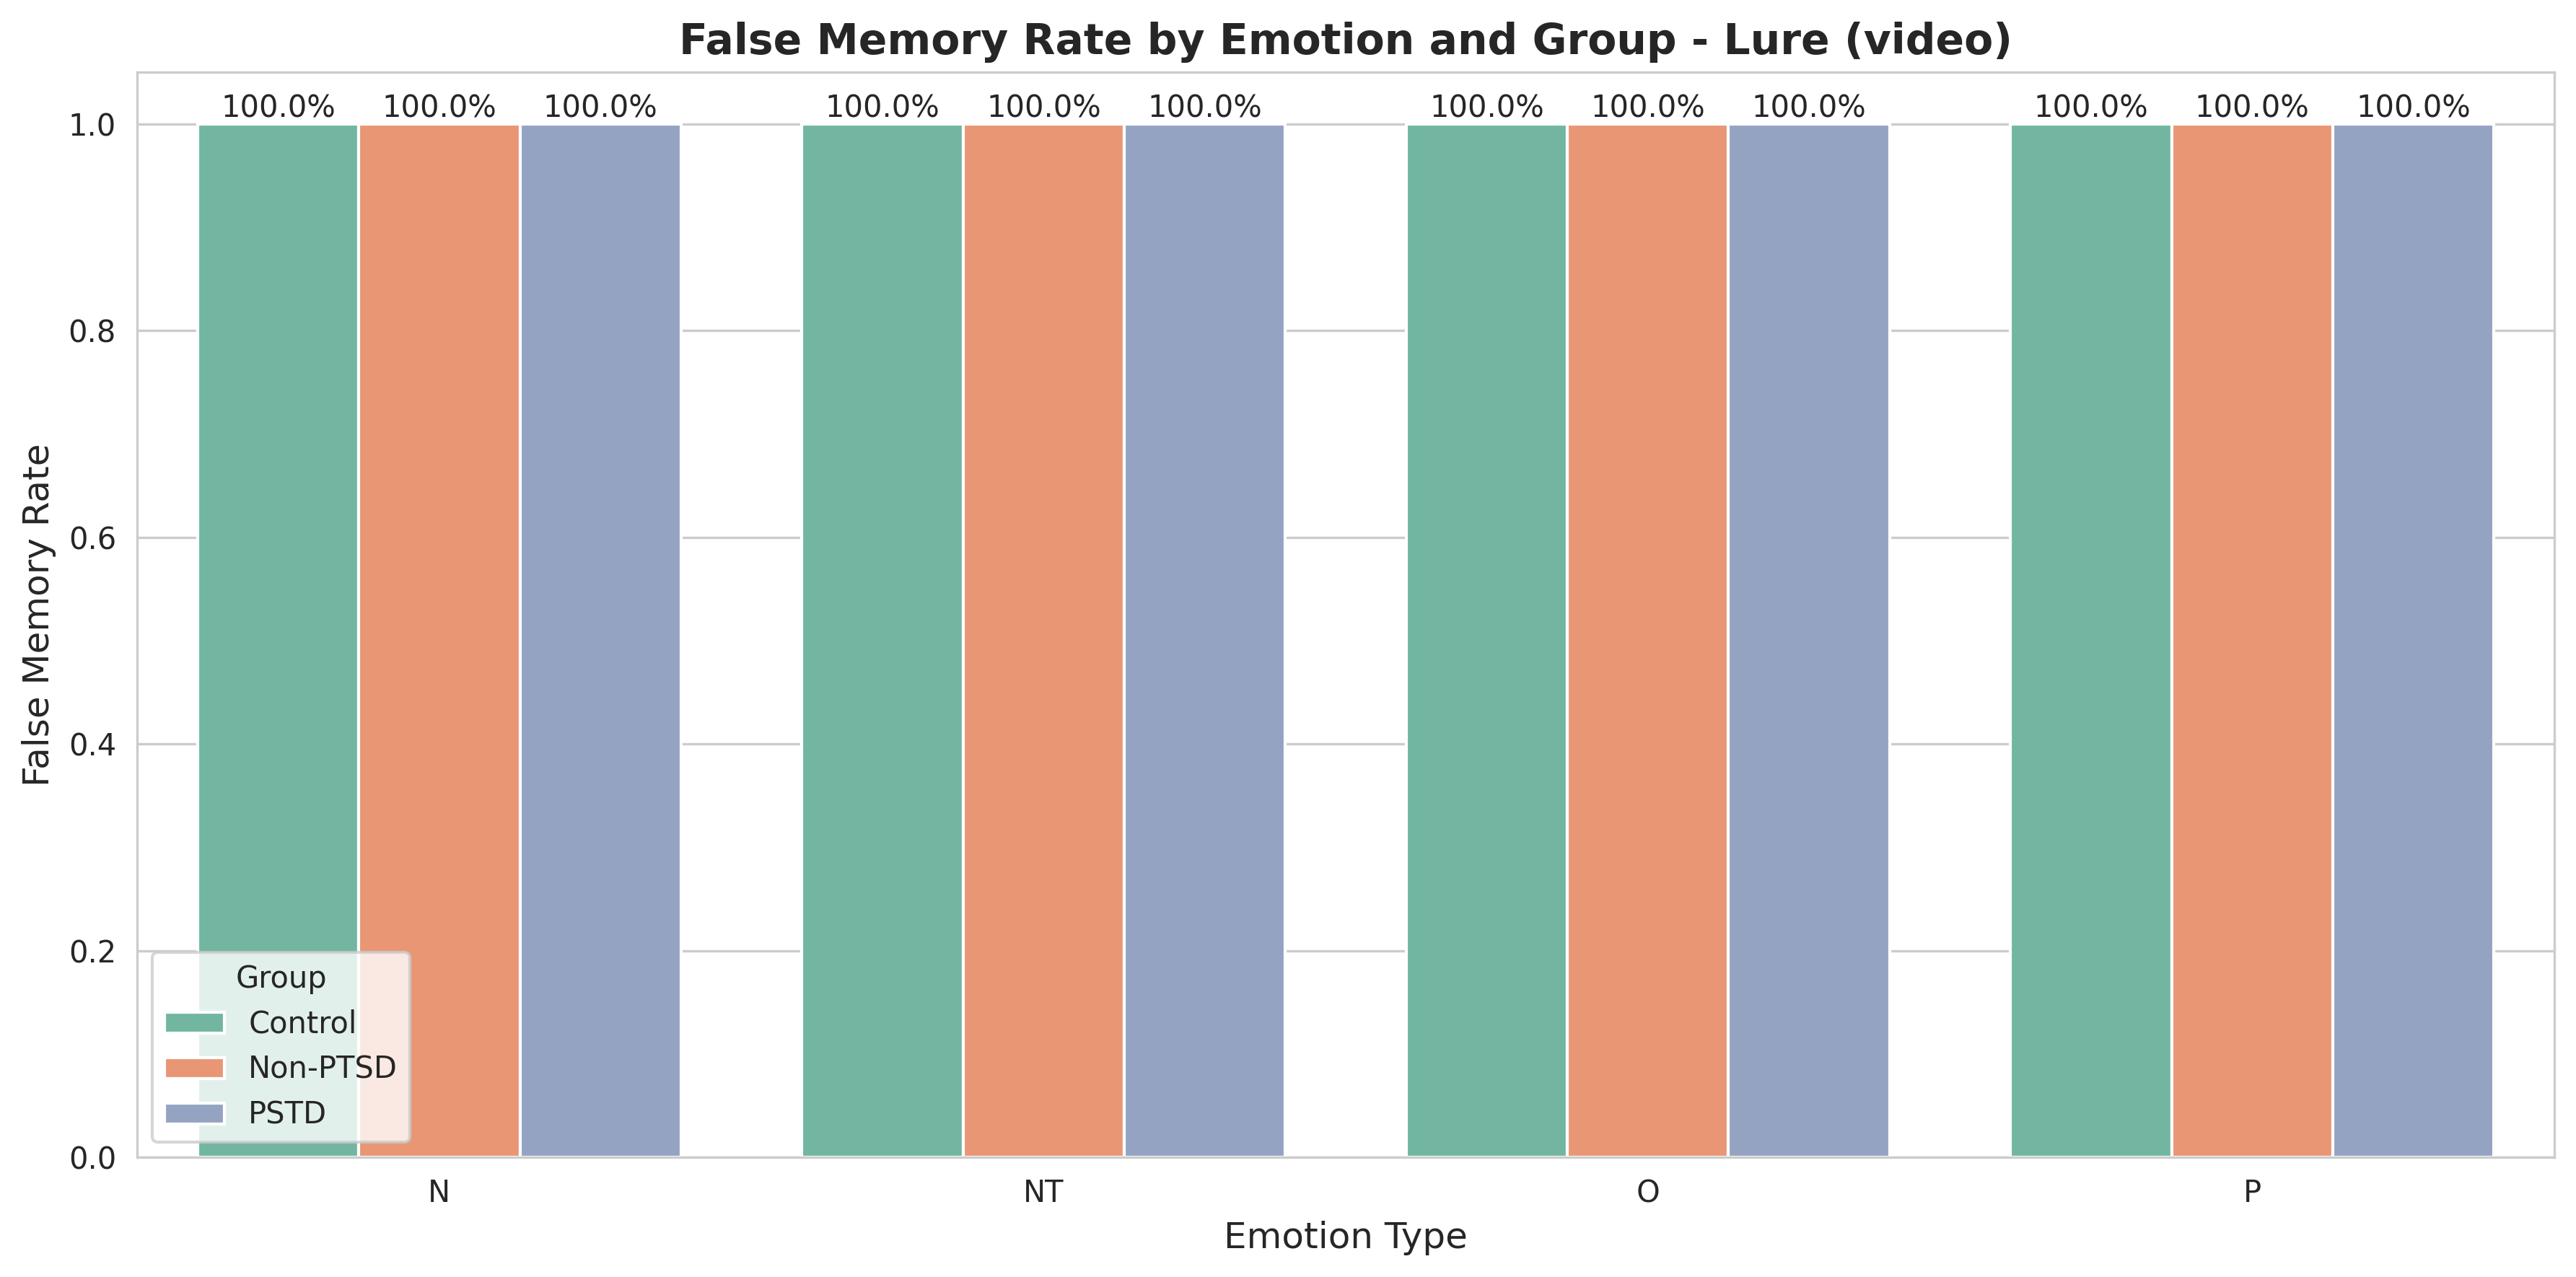

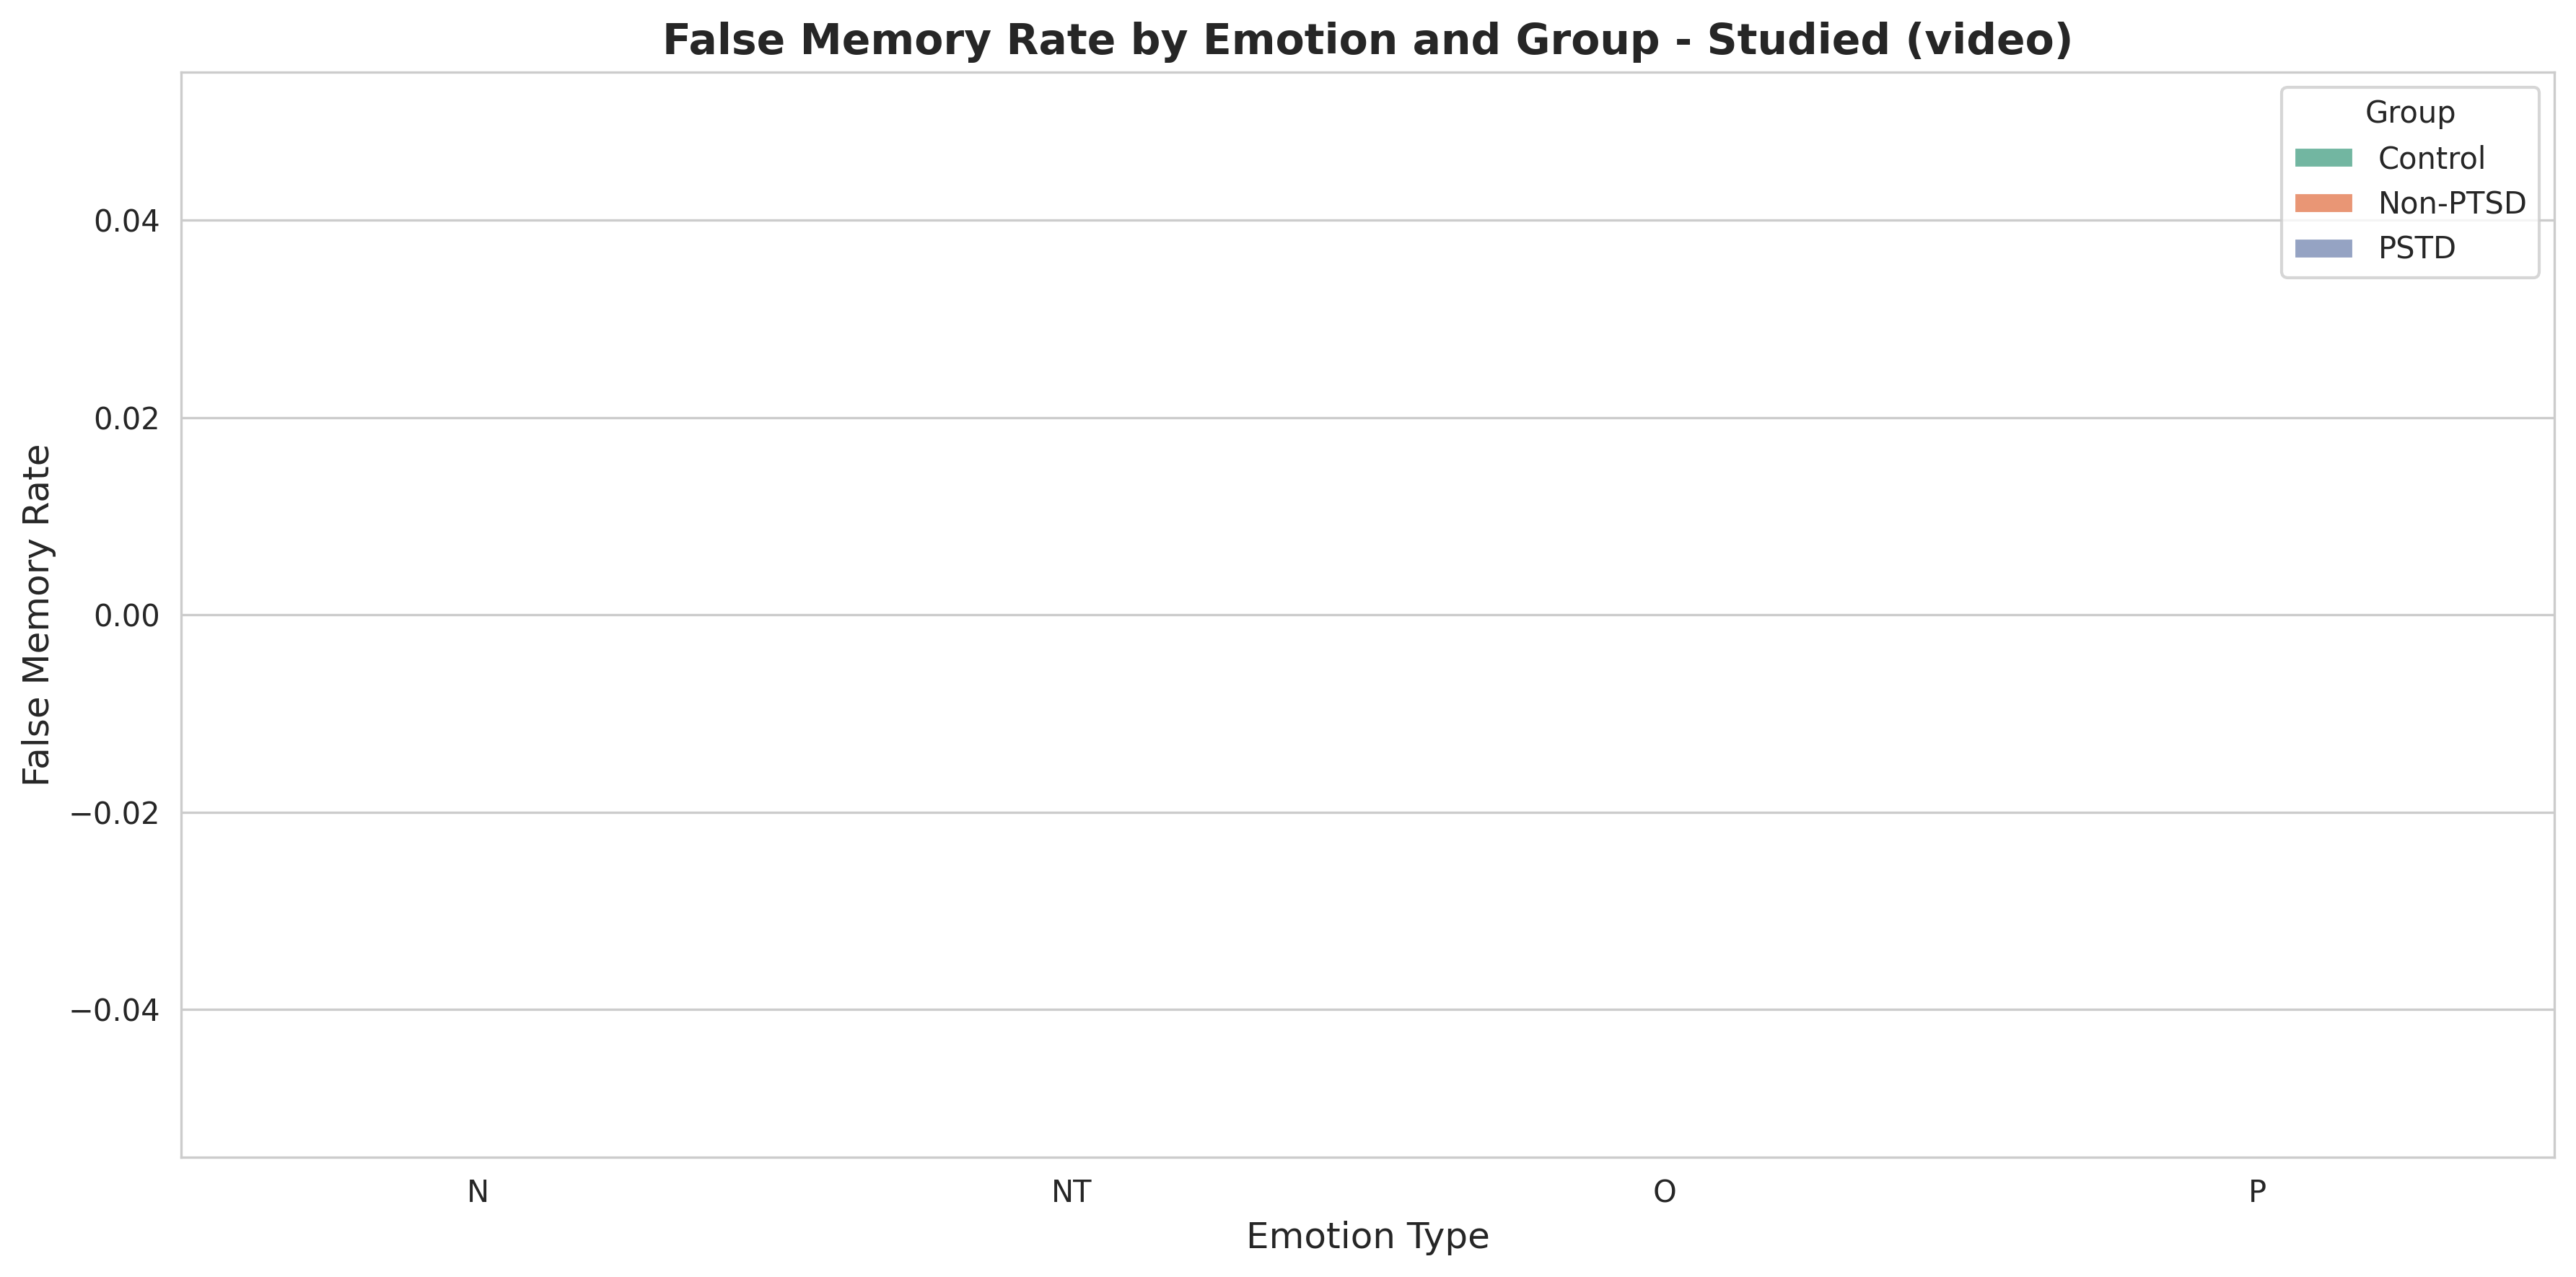

In [27]:
def main():
    """
    Main execution pipeline for PTSD false memory analysis.
    This orchestrates all analysis steps in the correct order.
    """

    print("\n" + "="*80)
    print("PTSD FALSE MEMORY ANALYSIS - BACHELOR THESIS")
    print("Statistical Analysis of False Memory in Iran-Iraq War PTSD Patients")
    print("="*80 + "\n")

    # -------------------------------------------------------------------------
    # STEP 1: DATA LOADING AND PREPROCESSING
    # -------------------------------------------------------------------------
    print("STEP 1: DATA LOADING AND PREPROCESSING")
    print("-" * 80 + "\n")

    all_data = []
    for file_key, file_path in FILES.items():
        processed = process_file(file_path, file_key)
        if processed is not None:
            all_data.append(processed)

    if not all_data:
        print("❌ ERROR: No data files were successfully processed!")
        return

    # Combine all data
    full_df_original = pd.concat(all_data, ignore_index=True)
    full_df_original.to_excel(os.path.join(OUTPUT_DIR, 'full_data_original.xlsx'), index=False)
    print(f"\n✅ Combined data: {len(full_df_original)} trials, {full_df_original['candidate'].nunique()} subjects\n")

    # Save copy for sensitivity analysis (before imputation)
    full_df_no_impute = full_df_original.copy()

    # -------------------------------------------------------------------------
    # STEP 2: DATA QUALITY REPORT
    # -------------------------------------------------------------------------
    print("\nSTEP 2: DATA QUALITY REPORT")
    print("-" * 80 + "\n")

    quality_report = full_df_original.groupby(['group', 'task']).agg(
        n_subjects=('candidate', 'nunique'),
        n_trials=('response', 'count'),
        pct_missing_response=('response', lambda x: x.isna().mean() * 100),
        pct_missing_rt=('rt', lambda x: x.isna().mean() * 100),
        n_negative_rt=('rt', lambda x: (x.isna() & (full_df_original.loc[x.index, 'response'] == 1)).sum())
    ).reset_index()

    quality_report.to_excel(os.path.join(OUTPUT_DIR, 'data_quality_report.xlsx'), index=False)
    print("📋 Data Quality Report:")
    print(quality_report.to_string(index=False))
    print()

    # -------------------------------------------------------------------------
    # STEP 3: RT IMPUTATION
    # -------------------------------------------------------------------------
    print("\nSTEP 3: REACTION TIME IMPUTATION")
    print("-" * 80 + "\n")

    full_df = impute_negative_rt(full_df_original)
    full_df.to_excel(os.path.join(OUTPUT_DIR, 'full_data_imputed.xlsx'), index=False)

    # -------------------------------------------------------------------------
    # STEP 4: SEPARATE TASKS
    # -------------------------------------------------------------------------
    print("\nSTEP 4: SEPARATING VERBAL AND VIDEO TASKS")
    print("-" * 80 + "\n")

    verbal_df = full_df[full_df['task'] == 'verbal'].copy()
    video_df = full_df[full_df['task'] == 'video'].copy()

    print(f"✅ Verbal: {len(verbal_df)} trials, {verbal_df['candidate'].nunique()} subjects")
    print(f"✅ Video: {len(video_df)} trials, {video_df['candidate'].nunique()} subjects\n")

    # -------------------------------------------------------------------------
    # STEP 5: AGGREGATION
    # -------------------------------------------------------------------------
    print("\nSTEP 5: DATA AGGREGATION TO SUBJECT LEVEL")
    print("-" * 80 + "\n")

    agg_verbal = aggregate_data(verbal_df, 'verbal')
    agg_video = aggregate_data(video_df, 'video')

    # -------------------------------------------------------------------------
    # STEP 6: DESCRIPTIVE STATISTICS
    # -------------------------------------------------------------------------
    print("\nSTEP 6: DESCRIPTIVE STATISTICS")
    print("-" * 80 + "\n")

    desc_verbal = calculate_descriptives(agg_verbal, 'verbal')
    desc_video = calculate_descriptives(agg_video, 'video')

    # -------------------------------------------------------------------------
    # STEP 7: ASSUMPTIONS TESTING
    # -------------------------------------------------------------------------
    print("\nSTEP 7: TESTING STATISTICAL ASSUMPTIONS")
    print("-" * 80 + "\n")

    norm_verbal, homog_verbal = test_assumptions(agg_verbal, 'verbal')
    norm_video, homog_video = test_assumptions(agg_video, 'video')

    # -------------------------------------------------------------------------
    # STEP 8: INFERENTIAL STATISTICS
    # -------------------------------------------------------------------------
    print("\nSTEP 8: INFERENTIAL STATISTICAL TESTS")
    print("-" * 80 + "\n")

    run_statistical_tests(agg_verbal, 'verbal')
    run_statistical_tests(agg_video, 'video')

    # Load results for thesis generation
    stat_results_verbal = {}
    stat_results_video = {}

    for result_type in ['friedman', 'kruskal', 'posthoc']:
        verbal_path = os.path.join(OUTPUT_DIR, f'{result_type}_verbal.xlsx')
        video_path = os.path.join(OUTPUT_DIR, f'{result_type}_video.xlsx')

        if os.path.exists(verbal_path):
            stat_results_verbal[result_type] = pd.read_excel(verbal_path)
        if os.path.exists(video_path):
            stat_results_video[result_type] = pd.read_excel(video_path)

    # -------------------------------------------------------------------------
    # STEP 9: POWER ANALYSIS
    # -------------------------------------------------------------------------
    print("\nSTEP 9: STATISTICAL POWER ANALYSIS")
    print("-" * 80 + "\n")

    power_verbal = calculate_power_analysis(agg_verbal, 'verbal')
    power_video = calculate_power_analysis(agg_video, 'video')

    # -------------------------------------------------------------------------
    # STEP 10: VISUALIZATIONS
    # -------------------------------------------------------------------------
    print("\nSTEP 10: CREATING VISUALIZATIONS")
    print("-" * 80 + "\n")

    create_visualizations(agg_verbal, 'verbal', desc_verbal)
    create_visualizations(agg_video, 'video', desc_video)

    # -------------------------------------------------------------------------
    # STEP 11: SENSITIVITY ANALYSIS
    # -------------------------------------------------------------------------
    print("\nSTEP 11: SENSITIVITY ANALYSIS")
    print("-" * 80 + "\n")

    sensitivity_df, sensitivity_comparison = sensitivity_analysis(full_df_no_impute, full_df)

    # -------------------------------------------------------------------------
    # STEP 12: GENERATE THESIS TEXT
    # -------------------------------------------------------------------------
    print("\nSTEP 12: GENERATING THESIS CHAPTER 4 TEXT")
    print("-" * 80 + "\n")

    thesis_verbal = generate_thesis_snippets(desc_verbal, stat_results_verbal, power_verbal, 'verbal')
    thesis_video = generate_thesis_snippets(desc_video, stat_results_video, power_video, 'video')

    # -------------------------------------------------------------------------
    # FINAL SUMMARY
    # -------------------------------------------------------------------------
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE!")
    print("="*80 + "\n")

    print("📁 All outputs saved to:", OUTPUT_DIR)
    print("\n📊 Generated Files:")
    print("   - Data: full_data_original.xlsx, full_data_imputed.xlsx")
    print("   - Aggregated: aggregated_verbal.xlsx, aggregated_video.xlsx")
    print("   - Descriptives: descriptives_verbal.xlsx, descriptives_video.xlsx")
    print("   - Tests: friedman_*.xlsx, kruskal_*.xlsx, posthoc_*.xlsx")
    print("   - Power: power_analysis_verbal.xlsx, power_analysis_video.xlsx")
    print("   - Sensitivity: sensitivity_analysis.xlsx, sensitivity_comparison.xlsx")
    print("   - Visualizations: bar_*.png, box_*.png")
    print("   - Thesis Text: thesis_chapter4_verbal.txt, thesis_chapter4_video.txt")

    print("\n✅ Ready for thesis Chapter 4 (Results) and Chapter 5 (Discussion)!")
    print("\n" + "="*80 + "\n")


# ============================================================================
# RUN THE ANALYSIS
# ============================================================================

if __name__ == "__main__":
    main()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')